# Gathering the Data

In [ ]:
!pip install holidays pytrends yfinance fredapi

In [ ]:
import numpy as np
import random
import os

# Reporducibility
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    print(f"Seeds locked with seed: {seed}")

set_reproducibility(210)

Seeds locked with seed: 210


In [ ]:
import pandas as pd

# Load the datasets
train_df = pd.read_csv('tsa_train.csv')
test_df = pd.read_csv('tsa_test.csv')

train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

print(f"Training range: {train_df['Date'].min()} to {train_df['Date'].max()}")

Training range: 2022-01-01 00:00:00 to 2025-07-01 00:00:00


In [ ]:
import holidays

def get_holiday_features(df):
    us_holidays = holidays.US()
    # 1. Federal Holiday Flag
    df['is_federal_holiday'] = df['Date'].apply(lambda x: x in us_holidays).astype(int)

    # 2. Distance to Holiday
    holiday_dates = [date for date in us_holidays.keys() if date.year >= 2019]
    df['days_to_holiday'] = df['Date'].apply(lambda x: min([(h - x.date()).days for h in holiday_dates if (h - x.date()).days >= 0] or [0]))

    # 3. Major School Holidays (Spring Break/Summer)
    df['is_summer_break'] = df['Date'].dt.month.isin([6, 7, 8]).astype(int)
    df['is_spring_break'] = df['Date'].dt.month.isin([3]).astype(int)
    return df

In [ ]:
import yfinance as yf

# Fetching Jet Fuel Proxy (Crude Oil Prices)
oil_data = yf.download("CL=F", start="2019-01-01", end="2025-07-01")['Close']
oil_data = oil_data.reset_index()
oil_data.columns = ['Date', 'oil_price']

# Merge with the training dataframe
train_df = train_df.merge(oil_data, on='Date', how='left').ffill()

/tmp/ipython-input-3056426656.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  oil_data = yf.download("CL=F", start="2019-01-01", end="2025-07-01")['Close']
[*********************100%***********************]  1 of 1 completed


# Generating features/Training


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def create_advanced_features(df, lag_days=[7, 14, 30]):
    df = df.copy()
    df = df.sort_values('Date')

    # 1. Temporal Features
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month

    # 2. Cyclical Encoding
    # This connects Sunday (6) back to Monday (0)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    df['month_sin'] = np.sin(2 * np.pi * (df['month']-1) / 12)
    df['month_cos'] = np.cos(2 * np.pi * (df['month']-1) / 12)

    # 3. Lag Features (Previous values)
    for lag in lag_days:
        df[f'lag_{lag}'] = df['Volume'].shift(lag)

    # 4. Rolling Windows (Moving Averages)
    df['rolling_mean_7'] = df['Volume'].shift(1).rolling(window=7).mean()
    df['rolling_std_7'] = df['Volume'].shift(1).rolling(window=7).std()

    # 5. Drop rows with NaNs created by lagging
    return df.dropna().reset_index(drop=True)

# Process the training data
full_train_df = create_advanced_features(train_df)

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Define features and target
features = ['day_sin', 'day_cos', 'month_sin', 'month_cos',
            'lag_7', 'lag_14', 'lag_30', 'rolling_mean_7', 'rolling_std_7']
X = full_train_df[features]
y = full_train_df['Volume']

# Initialize TimeSeriesSplit (5 folds)
tscv = TimeSeriesSplit(n_splits=5)

fold = 1
for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train Model
    model = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=50)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)

    print(f"Fold {fold} MAE: {mae:.2f}")
    fold += 1

Fold 1 MAE: 140808.55
Fold 2 MAE: 178018.31
Fold 3 MAE: 133554.00
Fold 4 MAE: 137928.39
Fold 5 MAE: 116185.02


In [ ]:

from pytrends.request import TrendReq
from xgboost import XGBRegressor


# --- STEP 0: RESET DATA (Prevents MergeErrors) ---
train_df = pd.read_csv('tsa_train.csv')
test_df = pd.read_csv('tsa_test.csv')
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# --- STEP 1: EXTERNAL DATA INTEGRATION ---
print("Fetching oil prices...")
# auto_adjust=True handles a warning from te libarby
oil_data_raw = yf.download("CL=F", start="2019-01-01", end="2026-02-01", auto_adjust=True)

# Extract the 'Close' price regardless
if isinstance(oil_data_raw.columns, pd.MultiIndex):
    oil_data = oil_data_raw['Close'].reset_index()
else:
    oil_data = oil_data_raw[['Close']].reset_index()

oil_data.columns = ['Date', 'oil_price']

def get_daily_trends(start_date, end_date):
    print("Fetching Google Trends...")
    pytrends = TrendReq(hl='en-US', tz=360)
    kw_list = ["flights", "expedia", "trivago", "vacation", "airbnb"]
    pytrends.build_payload(kw_list, cat=0, timeframe=f'{start_date} {end_date}', geo='US')
    trends = pytrends.interest_over_time()
    if not trends.empty:
        trends = trends.drop(columns=['isPartial']).reset_index()
        trends = trends.rename(columns={'date': 'Date'})
    return trends

trends_raw = get_daily_trends('2019-01-01', '2026-02-01')

def merge_external_data(df, oil, trends):
    # Ensure datetime for merging
    df['Date'] = pd.to_datetime(df['Date'])
    oil['Date'] = pd.to_datetime(oil['Date'])
    trends['Date'] = pd.to_datetime(trends['Date'])

    # Standardize: Drop external columns if they exist (prevents suffix errors)
    ext_cols = ['oil_price', 'flights', 'expedia', 'trivago', 'vacation', 'airbnb']
    df = df.drop(columns=[c for c in ext_cols if c in df.columns])

    df = df.merge(oil, on='Date', how='left')
    df = df.merge(trends, on='Date', how='left')

    # Fill gaps (Weekends for oil, weekly for trends)
    return df.sort_values('Date').ffill().bfill()

# Apply merges
train_df = merge_external_data(train_df, oil_data, trends_raw)
test_df = merge_external_data(test_df, oil_data, trends_raw)

# Apply other functions
train_df = get_holiday_features(train_df)
test_df = get_holiday_features(test_df)

print("External data integration complete.")

# --- STEP 2: FINAL MODEL TRAINING ---
# Prepare the training features
full_train_processed = create_advanced_features(train_df)

features = [
    'day_sin', 'day_cos', 'month_sin', 'month_cos',
    'lag_7', 'lag_14', 'lag_30', 'rolling_mean_7', 'rolling_std_7',
    'is_federal_holiday', 'days_to_holiday', 'oil_price',
    'flights', 'expedia', 'trivago', 'vacation', 'airbnb'
]

X_final = full_train_processed[features]
y_final = full_train_processed['Volume']

print("Training final XGBoost model...")
final_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

final_model.fit(X_final, y_final)
print("Final model training finished successfully")

[*********************100%***********************]  1 of 1 completed

Fetching oil prices...
Fetching Google Trends...



/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


External data integration complete.
Training final XGBoost model...
Final model training finished successfully


In [ ]:
import matplotlib.pyplot as plt

# --- 1. PREPARE THE COMBINED DATAFRAME ---
seed_data = train_df.tail(30).copy()
forecast_df = test_df.copy()
forecast_df['Volume'] = np.nan # Hide the real values

combined = pd.concat([seed_data, forecast_df], axis=0).reset_index(drop=True)

# --- 2. ADD DETERMINISTIC FEATURES (Sin/Cos/Date parts) ---
combined['day_of_week'] = combined['Date'].dt.dayofweek
combined['month'] = combined['Date'].dt.month

combined['day_sin'] = np.sin(2 * np.pi * combined['day_of_week'] / 7)
combined['day_cos'] = np.cos(2 * np.pi * combined['day_of_week'] / 7)
combined['month_sin'] = np.sin(2 * np.pi * (combined['month']-1) / 12)
combined['month_cos'] = np.cos(2 * np.pi * (combined['month']-1) / 12)

# Initialize the Lag/Rolling columns with 0 so the model has a column to look at
for col in ['lag_7', 'lag_14', 'lag_30', 'rolling_mean_7', 'rolling_std_7']:
    combined[col] = 0.0

# --- 3. THE RECURSIVE LOOP ---
start_idx = len(seed_data)
print(f"Starting recursive forecast for {len(forecast_df)} days...")

for i in range(start_idx, len(combined)):
    # A. Update Lags based on our OWN previous predictions
    combined.loc[i, 'lag_7'] = combined.loc[i-7, 'Volume']
    combined.loc[i, 'lag_14'] = combined.loc[i-14, 'Volume']
    combined.loc[i, 'lag_30'] = combined.loc[i-30, 'Volume']
    combined.loc[i, 'rolling_mean_7'] = combined.loc[i-7:i-1, 'Volume'].mean()
    combined.loc[i, 'rolling_std_7'] = combined.loc[i-7:i-1, 'Volume'].std()

    # B. Predict using the features list
    X_input = combined.loc[[i], features]
    prediction = final_model.predict(X_input)[0]

    # C. Store prediction
    combined.loc[i, 'Volume'] = prediction

print("Forecast complete!")

Starting recursive forecast for 211 days...
Forecast complete!


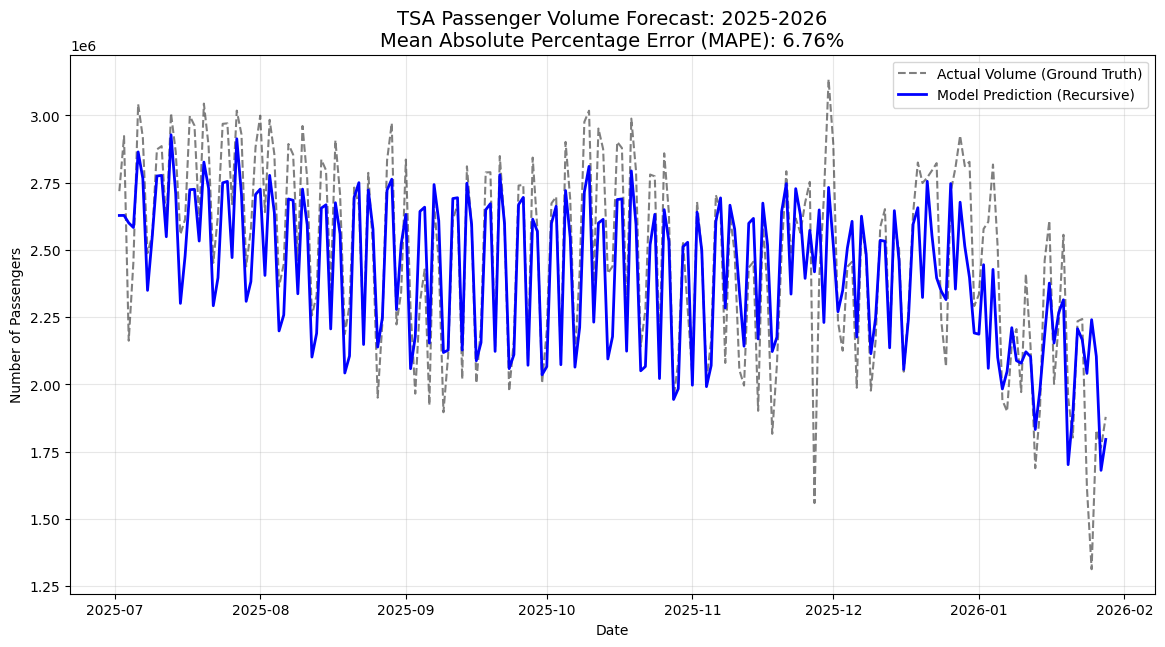

        Date     Actual   Predicted
0 2025-07-02  2718537.0  2628180.50
1 2025-07-03  2923234.0  2628394.25
2 2025-07-04  2162755.0  2600506.50
3 2025-07-05  2457591.0  2583462.75
4 2025-07-06  3041954.0  2864410.00


In [ ]:
# Extract the predictions and the actuals for comparison
# Note to self'test_df' still has the original real Volume from the CSV
results = pd.DataFrame({
    'Date': test_df['Date'],
    'Actual': test_df['Volume'],
    'Predicted': combined.iloc[start_idx:]['Volume'].values
})

# Calculate Accuracy Metric (MAPE)
results['APE'] = abs((results['Actual'] - results['Predicted']) / results['Actual']) * 100
mape = results['APE'].mean()

# --- PLOTTING ---
plt.figure(figsize=(14, 7))
plt.plot(results['Date'], results['Actual'], label='Actual Volume (Ground Truth)', color='black', alpha=0.5, linestyle='--')
plt.plot(results['Date'], results['Predicted'], label='Model Prediction (Recursive)', color='blue', linewidth=2)

plt.title(f'TSA Passenger Volume Forecast: 2025-2026\nMean Absolute Percentage Error (MAPE): {mape:.2f}%', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# First five predictions
print(results[['Date', 'Actual', 'Predicted']].head())

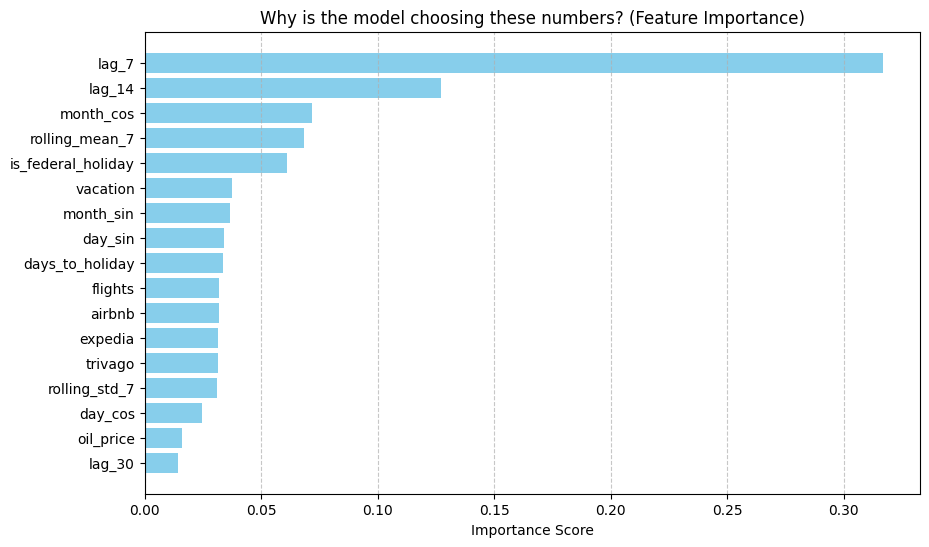

In [ ]:
# Extract feature importance from the XGBoost model
import pandas as pd
import matplotlib.pyplot as plt

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Why is the model choosing these numbers? (Feature Importance)')
plt.xlabel('Importance Score')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

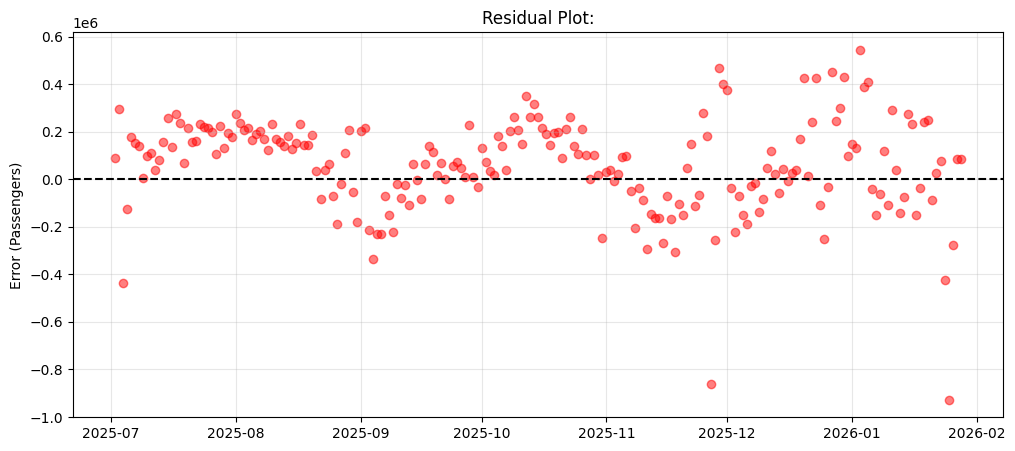

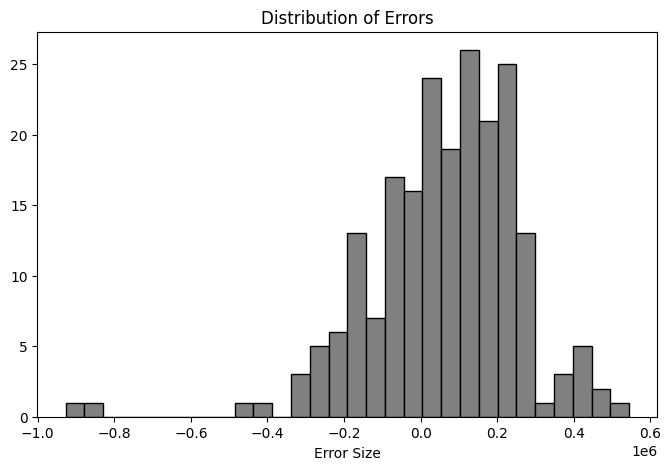

In [ ]:
results['Residual'] = results['Actual'] - results['Predicted']

plt.figure(figsize=(12, 5))
plt.scatter(results['Date'], results['Residual'], alpha=0.5, color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residual Plot:')
plt.ylabel('Error (Passengers)')
plt.grid(True, alpha=0.3)
plt.show()

# Histogram of errors
# Hm, not a normal distribution
plt.figure(figsize=(8, 5))
plt.hist(results['Residual'], bins=30, color='gray', edgecolor='black')
plt.title('Distribution of Errors')
plt.xlabel('Error Size')
plt.show()

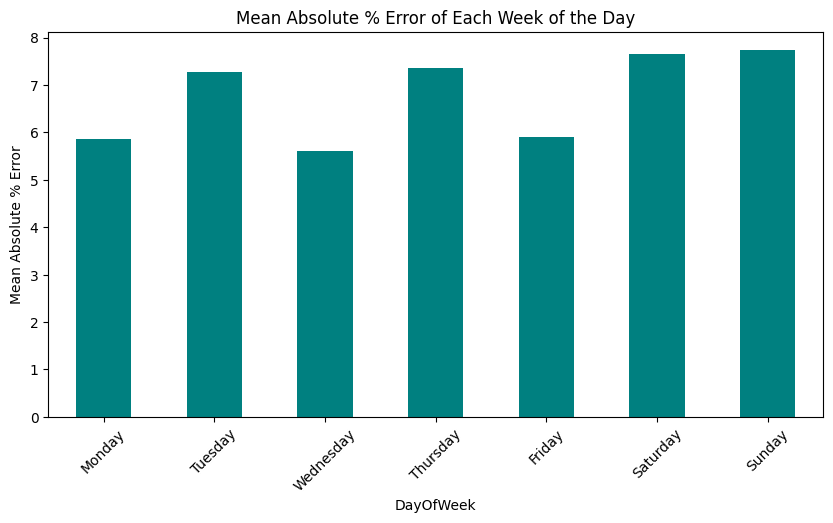

In [ ]:
results['DayOfWeek'] = results['Date'].dt.day_name()

# Average error per day
day_error = results.groupby('DayOfWeek')['APE'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

plt.figure(figsize=(10, 5))
day_error.plot(kind='bar', color='teal')
plt.title('Mean Absolute % Error of Each Week of the Day')
plt.ylabel('Mean Absolute % Error')
plt.xticks(rotation=45)
plt.show()

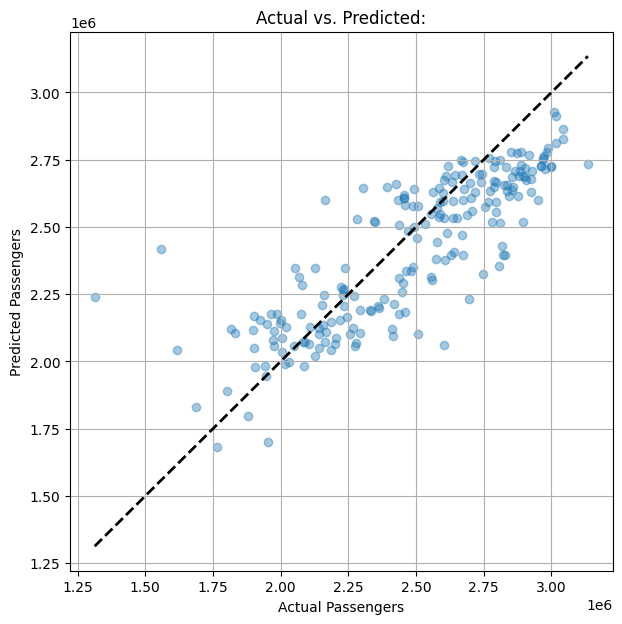

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(results['Actual'], results['Predicted'], alpha=0.4)
# Add a 45-degree line
max_val = max(results['Actual'].max(), results['Predicted'].max())
min_val = min(results['Actual'].min(), results['Predicted'].min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

plt.xlabel('Actual Passengers')
plt.ylabel('Predicted Passengers')
plt.title('Actual vs. Predicted:')
plt.grid(True)
plt.show()